## Preparing Data

In [125]:
import matplotlib as plt
%matplotlib inline
import numpy as np 
import pandas as pd 
import torch
import torchtext
from torchtext import data
import spacy
import os
import re

spacy_en = spacy.load('en')

_stopwords = spacy.lang.en.stop_words.STOP_WORDS

os.environ['OMP_NUM_THREADS'] = '4'


SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


def tokenizer(text):
    token = [t.text for t in spacy_en.tokenizer(text)]
#    if len(token) < FILTER_SIZES[-1]:
    for i in range(1, 7 ):
        token.append('<PAD>')
    return token


TEXT = data.Field(lower=True,include_lengths=False,tokenize=tokenizer, stop_words = _stopwords)

LABEL = data.Field(sequential=False, 
                         use_vocab=False, 
                         pad_token=None, 
                            unk_token=None, dtype = torch.float)




dataFields = {"comment_text": ("comment_text", TEXT), 
              'toxic': ("toxic", LABEL), 
              'severe_toxic': ("severe_toxic", LABEL),
              'threat': ("threat", LABEL), 
              'obscene': ("obscene", LABEL),
              'insult': ("insult", LABEL), 
              'identity_hate': ("identity_hate", LABEL)}



In [126]:
data_dir = '../data/'
data_name = 'resampled_train.json'

In [127]:
dataset= data.TabularDataset(path=data_dir+data_name, 
                                            format='json',
                                            fields=dataFields, 
                                            skip_header=True)

In [128]:
import random
SEED = 3
 

train_data, val_data = dataset.split(split_ratio=0.9,random_state = random.seed(SEED))

In [129]:
MAX_VOCAB_SIZE = 20_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

In [130]:
#import pickle

#pickle.dump(TEXT, open('./custom_embeddings/train_data_field', 'wb'))

In [131]:
TEXT.vocab

In [132]:
BATCH_SIZE = 256 #only change

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, val_data), 
    batch_size = BATCH_SIZE,
    sort_key=lambda x: len(x.comment_text),
    sort_within_batch = True,
    device = device)

In [133]:
for i in train_iterator:
    aux = i
    break

In [134]:
aux.comment_text[0]

tensor([   44,     0,   282, 18020,  2323,  3993,   583,     2,  2591,  2381,
        12761,  2074,  2304,   140,   282,   152,   429,     2,   282,    63,
         3127,   304,   556,   295,   518,     0,     0, 12088,   282,  4123,
          137,  3483,     0,   405,   103,    73, 11007,  1509,    31,   173,
          350,   424,     0,   280,     2,    31,    31,   161,  4877,   529,
         7574, 13301,  1218,    41,     0,  2165,   164,   242,  1070,   152,
          101,    44,    41,   103,    45,  3015,     3,     0,   583,    32,
         6634, 13149,     3,  2369,     0,   366,   214,   782,  1832,  1269,
           49,   355,    26,   103,     0, 19294,   287,   337,   109,   937,
         1623,   266,  3971,   252,   701,  5597,  1951,    16,   472,   179,
         4549,     0,    19,   171,  3922,   147,   282,   217,  3221,  3999,
          600,   355,   545,    31,   157,   184,    67,  5026,     0,   282,
            0,  1767,    19,  1505,  1102,   748,   468,   184, 

In [135]:
yFields = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
iaux=0
for batch in valid_iterator:
    iaux+=1
    aux = batch
    aux2= torch.stack([getattr(batch, y) for y in yFields])
    if iaux==20: break

In [136]:

        
torch.transpose( torch.stack([getattr(aux, y) for y in yFields]),0,1)

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

In [137]:
aux.comment_text[0].size()

torch.Size([256])

In [138]:
aux.toxic.size()

torch.Size([256])

## Build model

In [139]:
import torch.nn as nn
from torch.functional import F
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)


In [140]:
INPUT_DIM = len(TEXT.vocab) # 20002
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2,3,4,5,6]
OUTPUT_DIM = 6
DROPOUT = 0.8
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # 1

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES ,OUTPUT_DIM, DROPOUT, PAD_IDX)

In [141]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,203,706 trainable parameters


In [142]:
for i in train_iterator:
    aux=i
    break

from torchsummaryX import summary
print(aux.comment_text.size())
summary(model, aux.comment_text )

torch.Size([191, 256])
                      Kernel Shape        Output Shape   Params Mult-Adds
Layer                                                                    
0_embedding           [100, 20002]     [256, 191, 100]  2.0002M   2.0002M
1_convs.Conv2d_0  [1, 100, 2, 100]  [256, 100, 190, 1]    20.1k      3.8M
2_convs.Conv2d_1  [1, 100, 3, 100]  [256, 100, 189, 1]    30.1k     5.67M
3_convs.Conv2d_2  [1, 100, 4, 100]  [256, 100, 188, 1]    40.1k     7.52M
4_convs.Conv2d_3  [1, 100, 5, 100]  [256, 100, 187, 1]    50.1k     9.35M
5_convs.Conv2d_4  [1, 100, 6, 100]  [256, 100, 186, 1]    60.1k    11.16M
6_dropout                        -          [256, 500]        -         -
7_fc                      [500, 6]            [256, 6]   3.006k      3.0k
-----------------------------------------------------------------------------
                         Totals
Total params          2.203706M
Trainable params      2.203706M
Non-trainable params        0.0
Mult-Adds              39.5032M

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_embedding,"[100, 20002]","[256, 191, 100]",2000200.0,2000200.0
1_convs.Conv2d_0,"[1, 100, 2, 100]","[256, 100, 190, 1]",20100.0,3800000.0
2_convs.Conv2d_1,"[1, 100, 3, 100]","[256, 100, 189, 1]",30100.0,5670000.0
3_convs.Conv2d_2,"[1, 100, 4, 100]","[256, 100, 188, 1]",40100.0,7520000.0
4_convs.Conv2d_3,"[1, 100, 5, 100]","[256, 100, 187, 1]",50100.0,9350000.0
5_convs.Conv2d_4,"[1, 100, 6, 100]","[256, 100, 186, 1]",60100.0,11160000.0
6_dropout,-,"[256, 500]",NaN,NaN
7_fc,"[500, 6]","[256, 6]",3006.0,3000.0


In [143]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([20002, 100])


In [144]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-1.0889,  0.1550,  0.3195,  ..., -0.5389, -0.0420, -0.2176],
        ...,
        [ 1.3330,  0.2984,  1.5541,  ...,  0.3570,  0.1128,  0.7918],
        [-0.0296,  0.9497,  0.1028,  ...,  0.0112,  0.0560, -0.2208],
        [ 0.0578,  0.0760, -0.1415,  ...,  0.8504,  0.2324,  0.3153]])

In [145]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-1.0889,  0.1550,  0.3195,  ..., -0.5389, -0.0420, -0.2176],
        ...,
        [ 1.3330,  0.2984,  1.5541,  ...,  0.3570,  0.1128,  0.7918],
        [-0.0296,  0.9497,  0.1028,  ...,  0.0112,  0.0560, -0.2208],
        [ 0.0578,  0.0760, -0.1415,  ...,  0.8504,  0.2324,  0.3153]])


In [146]:
print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-1.0889,  0.1550,  0.3195,  ..., -0.5389, -0.0420, -0.2176],
        ...,
        [ 1.3330,  0.2984,  1.5541,  ...,  0.3570,  0.1128,  0.7918],
        [-0.0296,  0.9497,  0.1028,  ...,  0.0112,  0.0560, -0.2208],
        [ 0.0578,  0.0760, -0.1415,  ...,  0.8504,  0.2324,  0.3153]])


## Train our model

In [147]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [148]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [149]:
import numpy
from sklearn.metrics import roc_auc_score
def roc_auc(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    #rounded_preds = torch.sigmoid(preds)
    
    #assert preds.size()==y.size()
    
    #reds=rounded_preds.detach().numpy()

    #y=y.numpy()
    
    global var_y
    global var_preds
    var_y = y
    var_preds = preds

    acc = roc_auc_score(y, preds)

    
    return acc

In [150]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    preds_list=[]
    labels_list= []
    epoch_loss_hist = []

    
    j = len(iterator)//10
    for i, batch in enumerate(iterator):
        
        optimizer.zero_grad()
        
        text = batch.comment_text
        
        predictions = model(text)
        
        batch_labels=torch.stack([getattr(batch, y) for y in yFields]) #transpose?
        batch_labels = torch.transpose(batch_labels,0,1)
        
        loss = criterion(predictions, batch_labels)
        
        loss.backward()
        
        optimizer.step()
        
        preds_list+=[torch.sigmoid(predictions).detach().numpy()]
        labels_list+=[batch_labels.numpy()]
        

                    
        epoch_loss += loss.item()
        
        if i%j ==0:
            epoch_loss_hist.append([loss.item(),
            evaluate(model, valid_iterator, criterion)[0]])
            model.train()
        
    return (epoch_loss / len(iterator) , epoch_loss_hist, 
           roc_auc_score(np.vstack(labels_list), np.vstack(preds_list)))

In [151]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    preds_list=[]
    labels_list= []
    epoch_acc=[]


    
    with torch.no_grad():
        i=0
        for batch in iterator:
            i+=1
            text = batch.comment_text
            
            predictions = model(text)#.squeeze(1)
            
            batch_labels = torch.stack([getattr(batch, y) for y in yFields]) #transpose?
            batch_labels = torch.transpose(batch_labels,0,1)
            
            loss = criterion(predictions, batch_labels)

            epoch_loss += loss.item()

            
            preds_list+=[torch.sigmoid(predictions).detach().numpy()]
            labels_list+=[batch_labels.numpy()]
            
        
    return (epoch_loss / len(iterator),
           roc_auc_score(np.vstack(labels_list), np.vstack(preds_list)) ,
           np.vstack(preds_list), np.vstack(labels_list))

In [152]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [153]:
model.embedding.weight.requires_grad = False

N_EPOCHS = 4
best_valid_loss = float('inf')
loss_hist= []
UNFREEZE = 4
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, _loss_hist, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc , _preds  , _labels  = evaluate(model, valid_iterator, criterion)
    end_time = time.time()
    
    loss_hist+= _loss_hist
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'ws-model.pt')
        

    if (epoch) > UNFREEZE:
        #unfreeze embeddings
        model.embedding.weight.requires_grad = True 
    
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


Epoch: 01 | Epoch Time: 6m 32s
	Train Loss: 0.095 | Train Acc: 85.56%
	 Val. Loss: 0.066 |  Val. Acc: 93.73%
Epoch: 02 | Epoch Time: 6m 36s
	Train Loss: 0.071 | Train Acc: 93.28%
	 Val. Loss: 0.061 |  Val. Acc: 95.16%
Epoch: 03 | Epoch Time: 6m 22s
	Train Loss: 0.067 | Train Acc: 94.51%
	 Val. Loss: 0.058 |  Val. Acc: 95.96%
Epoch: 04 | Epoch Time: 6m 27s
	Train Loss: 0.064 | Train Acc: 95.12%
	 Val. Loss: 0.057 |  Val. Acc: 96.14%


In [167]:
import matplotlib.pyplot as plt
%matplotlib inline


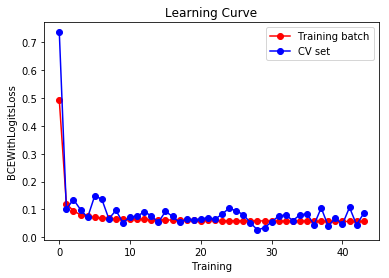

In [169]:
title = 'Learning Curve'
plt.title(title)
plt.plot([i[1] for i in loss_hist], 'o-', color="r",label= "Training batch")
plt.plot([i[0] for i in loss_hist],  'o-', color="b", label="CV set")
plt.legend(loc="best")
plt.xlabel("Training")
plt.ylabel("BCEWithLogitsLoss")
plt.savefig('../plots_tables/'+title.replace(' ', '_')+'.png')

In [155]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import pandas as pd


In [156]:
def print_metrics(pred, labels, thre= 0.5):
    toxic_labels = ['toxic','severe_toxic',
               'obscene','threat','insult',
               'identity_hate']
    
    roc_auc_scores= []
    recall_scores=[]
    precision_scores=[]
    accuracy_scores=[]
    f1_scores=[]

     
    for i,j in enumerate(toxic_labels):
        roc_auc_scores.append(roc_auc_score(labels[:,i], pred[:,i]))
        recall_scores.append(recall_score(labels[:,i], pred[:,i]>=thre))
        accuracy_scores.append(accuracy_score(labels[:,i], pred[:,i]>=thre))
        precision_scores.append(precision_score(labels[:,i], pred[:,i]>=thre))
        f1_scores.append(f1_score(labels[:,i], pred[:,i]>=thre))
    return pd.DataFrame(
    {'Label': toxic_labels,
     'accuracy': accuracy_scores,
     'recall': recall_scores,
     'precision': precision_scores,
     'f1': f1_scores,
     'roc_auc': roc_auc_scores})

In [157]:
print_metrics(_preds , _labels,0.5)

,Label,accuracy,recall,precision,f1,roc_auc
0,toxic,0.954753,0.609227,0.860153,0.713264,0.954455
1,severe_toxic,0.990913,0.163399,0.595238,0.256410,0.986255
2,obscene,0.976374,0.653236,0.851911,0.739461,0.979860
3,threat,0.997681,0.051282,1.000000,0.097561,0.926899
4,insult,0.971611,0.552457,0.781955,0.647471,0.968506
5,identity_hate,0.992918,0.090909,0.785714,0.162963,0.952552


In [471]:
_predicted_labels = _preds  
_true_labels = _labels

In [472]:

roc_auc_scores= []
recall_scores=[]
precision_scores=[]
accuracy_scores=[]
f1_scores=[]

thre = 0.5
for i,j in enumerate(toxic_labels):
    roc_auc_scores.append(roc_auc_score(_true_labels[:,i], _predicted_labels[:,i]))
    recall_scores.append(recall_score(_true_labels[:,i], _predicted_labels[:,i]>=thre))
    accuracy_scores.append(accuracy_score(_true_labels[:,i], _predicted_labels[:,i]>=thre))
    precision_scores.append(precision_score(_true_labels[:,i], _predicted_labels[:,i]>=thre))
    f1_scores.append(f1_score(_true_labels[:,i], _predicted_labels[:,i]>=thre))

/Users/rene/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rene/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [473]:
pd.DataFrame(
{'Label': toxic_labels,
 'accuracy': accuracy_scores,
 'recall': recall_scores,
 'precision': precision_scores,
 'f1': f1_scores,
 'roc_auc': roc_auc_scores})

,Label,accuracy,recall,precision,f1,roc_auc
0,toxic,0.959955,0.685306,0.871795,0.767383,0.974273
1,severe_toxic,0.990224,0.164706,0.666667,0.264151,0.982650
2,obscene,0.979821,0.776978,0.826531,0.800989,0.990320
3,threat,0.996365,0.000000,0.000000,0.000000,0.971068
4,insult,0.972614,0.552564,0.830443,0.663587,0.982024
5,identity_hate,0.992605,0.179104,0.750000,0.289157,0.974340


In [376]:
pd.DataFrame(
{'Label': toxic_labels,
 'accuracy': accuracy_scores,
 'recall': recall_scores,
 'precision': precision_scores,
 'f1': f1_scores,
 'roc_auc': roc_auc_scores})

,Label,accuracy,recall,precision,f1,roc_auc
0,toxic,0.960926,0.701754,0.875796,0.779175,0.969787
1,severe_toxic,0.989284,0.364162,0.508065,0.424242,0.986377
2,obscene,0.980228,0.754051,0.863486,0.805066,0.990308
3,threat,0.996428,0.058333,0.875000,0.109375,0.970779
4,insult,0.973241,0.625778,0.798887,0.701816,0.982739
5,identity_hate,0.992699,0.407143,0.629834,0.494577,0.978494


In [340]:
pd.DataFrame(
{'Label': toxic_labels,
 'accuracy': accuracy_scores,
 'recall': recall_scores,
 'precision': precision_scores,
 'f1': f1_scores,
 'roc_auc': roc_auc_scores})

,Label,accuracy,recall,precision,f1,roc_auc
0,toxic,0.960268,0.696332,0.873549,0.774938,0.969681
1,severe_toxic,0.989597,0.355491,0.530172,0.425606,0.986533
2,obscene,0.980698,0.769097,0.859638,0.811851,0.990549
3,threat,0.996397,0.050000,0.857143,0.094488,0.970718
4,insult,0.972332,0.630137,0.777863,0.696250,0.982357
5,identity_hate,0.992448,0.346429,0.625806,0.445977,0.978640


In [310]:
TEXT.vocab.vectors = model.embedding.weight.data

In [311]:
import pickle

pickle.dump(TEXT, open('./custom_embeddings/train_data_field', 'wb'))

FileNotFoundError: [Errno 2] No such file or directory: './custom_embeddings/train_data_field'

## Save word embedding

In [100]:
from tqdm import tqdm
word_list = [] 
def write_embeddings(path, embeddings, vocab):
    
    with open(path, 'w') as f:
        for i, embedding in enumerate(tqdm(embeddings)):
            word = vocab.itos[i]
            #skip words with unicode symbols
            if len(word) != len(word.encode()):
                continue
            word_list.append(word)
            vector = ' '.join([str(i) for i in embedding.tolist()])
            f.write(f'{word} {vector}\n')

In [25]:
write_embeddings('embeddings_conv.txt', 
                 model.embedding.weight.data, 
                 TEXT.vocab)

100%|██████████| 20002/20002 [00:02<00:00, 8001.79it/s]


In [46]:
list_apos = [w for w in word_list if ('\'' in w) | ('<' in w) | ('>' in w) ]
len(word_list) - len(list_apos)
#list_apos

19951

In [84]:
print(model.embedding.weight.data)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-1.0361, -0.3528, -0.4494,  ..., -0.3391, -0.0521, -0.2626],
        [-0.8892,  0.3043,  0.9224,  ..., -0.2417, -0.1520,  0.0683],
        [ 0.2916,  0.0795, -0.0095,  ...,  0.3854,  0.3772, -1.5852]])


In [26]:
# FREEZE_FOR = 4


#best_valid_loss = float('inf')

#freeze embeddings
#model.embedding.weight.requires_grad = unfrozen = False

#for epoch in range(N_EPOCHS):

#    start_time = time.time()
    
#    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
#    print('jaja')
#    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
#    print('juju')
#    end_time = time.time()

#    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
#    if valid_loss < best_valid_loss:
#        best_valid_loss = valid_loss
#        torch.save(model.state_dict(), 'tut2-model.pt')
#    else:
#        #unfreeze embeddings
#        model.embedding.weight.requires_grad = unfrozen = True

    
#    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
#    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
#    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

## Testing 

In [27]:
from sklearn import metrics

#roc_auc(np.vstack(preds_list), np.vstack(labels_list))

In [28]:
dataFields = {"comment_text": ("comment_text", TEXT)}

testDataset= data.TabularDataset(path='./data/test.json', 
                                            format='json',
                                            fields=dataFields, 
                                            skip_header=False)

In [29]:
len(testDataset)

153164

In [30]:
test_iterator = torchtext.data.Iterator(testDataset, batch_size=64, device=device, 
                                     sort=False, sort_within_batch=False, 
                                     repeat=False,shuffle=False)

In [31]:
myPreds=[]
with torch.no_grad():
    model.eval()
    for batch in test_iterator:

        torch.cuda.empty_cache()
    
        text = batch.comment_text    
        predictions = model(text).squeeze(1)         
        myPreds+=[torch.sigmoid(predictions).detach().numpy()]
    
        torch.cuda.empty_cache()
myPreds = np.vstack(myPreds)

In [32]:
testDF= pd.read_csv("./data/test.csv")
for i, col in enumerate(["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]):
    testDF[col] = myPreds[:, i]

In [33]:
myPreds.shape

(153164, 6)

In [34]:
testDF.drop("comment_text", axis=1).to_csv("submission_convolutional.csv", index=False)